# Visualizing Loss for an NN
---
This notebook contains code to train a neural net to predict an activity, running or walking, based on some provided user motion data. 

### The data

The data is a single csv file of accelerometer and gyroscope readings, collected from users' watches in 10 second intervals. Each data point is tagged as one of two activity types: running or walking. 

> Take a quick look at this data in Trove, where each column is described: [Run or walk data in Trove](https://trove.apple.com/dataset/run_walk_motion/1.0.0). 

### Visualizing loss functions

All of the code to define and train a simple neural net for this activity classification task is provided, however the model is not the best fit for this data and the training losses are unstable.

It is up to you to observe the training and validation loss values over several epochs, and determine whether this model is over- or under- fit (or if something else is going on). 

Then, try to change some of the training hyperparameters to make training more stable and improve this model! 

These tasks will be marked as **TASKS** in markdown. 

> **TASK**: Run the provided code to observe patterns in training and validation losses. 

In [1]:
## run provided code
# import PyTorch libraries
import torch
from torch.utils.data import DataLoader
torch.manual_seed(0) # reproducibility

# import data libraries
import turitrove as trove
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

/Users/noahgallego/miniconda3/envs/deep-learning/lib/python3.8/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


---
## Load the Data


The following cells load run/walk activity data from Trove and define a custom Dataset class to read in the csv of run/walk data as **Tensors** for PyTorch to work with.

In [2]:
# load data from Trove

TROVE_URI = 'dataset/run_walk_motion@1.0.0'
trove.umount(TROVE_URI)

# check for temp_data dir, if not found, make one and mount the dataset
if not os.path.isdir('temp_data'):
    os.makedirs('temp_data')

activity_dataset = trove.mount(TROVE_URI, 'temp_data')

dataset/run_walk_motion@1.0.0 is not mounted


/Users/noahgallego/miniconda3/envs/deep-learning/lib/python3.8/site-packages/httpx/_content.py:202: DeprecationWarning: Use 'content=<...>' to upload raw bytes/text content.
  warnings.warn(message, DeprecationWarning)


Directory /Users/noahgallego/Desktop/Apple-OBC/Loss_Vis_Ex/temp_data/run_walk_motion-1.0.0/data is created by trove.
mount in progress: /Users/noahgallego/Desktop/Apple-OBC/Loss_Vis_Ex/temp_data/run_walk_motion-1.0.0/data/table
26.3KB disk space allocated for caching /Users/noahgallego/Desktop/Apple-OBC/Loss_Vis_Ex/temp_data/run_walk_motion-1.0.0/data/table


100% (100 of 100) |######################################|Elapsed Time: 0:00:00/Users/noahgallego/miniconda3/envs/deep-learning/lib/python3.8/site-packages/httpx/_content.py:202: DeprecationWarning: Use 'content=<...>' to upload raw bytes/text content.
  warnings.warn(message, DeprecationWarning)



Mount succeeded
mount in progress: /Users/noahgallego/Desktop/Apple-OBC/Loss_Vis_Ex/temp_data/run_walk_motion-1.0.0/data/raw
7.2MB disk space allocated for caching /Users/noahgallego/Desktop/Apple-OBC/Loss_Vis_Ex/temp_data/run_walk_motion-1.0.0/data/raw


100% (100 of 100) |######################################|Elapsed Time: 0:00:02/Users/noahgallego/miniconda3/envs/deep-learning/lib/python3.8/site-packages/httpx/_content.py:202: DeprecationWarning: Use 'content=<...>' to upload raw bytes/text content.
  warnings.warn(message, DeprecationWarning)



Mount succeeded
dataset/run_walk_motion@1.0.0 is mounted at /Users/noahgallego/Desktop/Apple-OBC/Loss_Vis_Ex/temp_data


/Users/noahgallego/miniconda3/envs/deep-learning/lib/python3.8/site-packages/httpx/_content.py:202: DeprecationWarning: Use 'content=<...>' to upload raw bytes/text content.
  warnings.warn(message, DeprecationWarning)


In [3]:
# make dataframe from csv path
data_path = activity_dataset.raw_file_path + '/'+ activity_dataset.primary_index['path'][0]
df = pd.read_csv(data_path)

# format the data
# date, time, username columns dropped 
df_formatted = df.drop(['date', 'time', 'username'], axis=1)
# put target (activity) column last
column_order = ['wrist', 'acceleration_x', 'acceleration_y', 'acceleration_z', 
                'gyro_x', 'gyro_y', 'gyro_z','activity']
df_formatted = df_formatted.reindex(columns=column_order)
df_formatted.head()

,wrist,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,activity
0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296,0
1,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269,0
2,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367,0
3,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336,0
4,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922,0


In [4]:
if not os.path.isdir('data'):
    os.makedirs('data')
    
# save to local data/ dir
df_formatted.to_pickle('data/run_walk_formatted.pkl')

---
# Create a Dataset

Creating a Dataset class that defines input features as all columns of the `df_formatted` DataFrame _except_ for the last column, which is the target `activity` variable.

In [5]:
# create dataset
from helpers import RunWalkDataset
run_walk_dataset = RunWalkDataset('data/run_walk_formatted.pkl')

In [6]:
# print out a few (3) samples to see that it looks right
for i in range(3):
    sample = run_walk_dataset[i]
    print()
    print(sample)



(tensor([ 0.0000,  0.2650, -0.7814, -0.0076, -0.0590,  0.0325, -2.9296]), tensor([0.]))

(tensor([ 0.0000,  0.6722, -1.1233, -0.2344, -0.1757,  0.0208,  0.1269]), tensor([0.]))

(tensor([ 0.0000,  0.4399, -1.4817,  0.0722, -0.9105,  0.1063, -2.4367]), tensor([0.]))


---
## DataLoaders for Train/Validation/Test Datasets

DataLoaders allow us to do things like batch data (for batch learning), shuffle data, etc.—they are the standard way to iterate through data for training a PyTorch model.

> Notice how the `random_split()` utility function can be used to create 3 datasets of specified lengths (it can be used to create as many as you would like).

You can check that the validation dataset is ~10% of the entire data.

In [7]:
from torch.utils.data import random_split

# split data into train, validation, and test sets randomly ~ 70/10/20
split_10_float = len(run_walk_dataset)*1/10.0
split_70 = int(split_10_float*7)
split_10 = int(split_10_float)
split_20 = int(split_10_float*2)

# accounting for rounding errors, make sure I use all data by adding a few extra pts to training set
diff = len(run_walk_dataset) - (split_70 + split_10 + split_20)
# print(diff)
if diff > 0:
    split_70 += diff 


# create datasets and loaders
train_dataset, validation_dataset, test_dataset = random_split(run_walk_dataset, 
                                                              [split_70, split_10, split_20])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

---
# Define the Neural Network Architecture

The architecture is responsible for transforming input features into a single target class value between 0-1.  


In [91]:
# importing NN modules
import torch.nn as nn
import torch.nn.functional as F

class TwoLayerNet(nn.Module):
    
    ## Defines a single-layer NN
    def __init__(self, input_dim, hidden_dim, output_dim):
        '''Defines layers of a neural network.
           :param input_dim: Number of input features
           :param output_dim: Number of outputs
         '''
        super(TwoLayerNet, self).__init__()
                
        # define a linear layer, input > output
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    ## Defines the feedforward behavior of the network
    def forward(self, x):
        '''Feedforward behavior of the net.
           :param x: A batch of input features
           :return: A batch of output values; predictions
         '''
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        out = self.sigmoid(out) # final output, activation fn to get class probs 
        return out 

In [92]:
# instantiating the simple NN with specified dimensions
input_dim = 7 # input feats
output_dim = 1 # one target value
hidden_dim = 128 # nodes in hidden layer

model = TwoLayerNet(input_dim, hidden_dim, output_dim)
model

TwoLayerNet(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

---
# Train Loop

This training loop does the following:
* Iterate through the training data in batches provided by the `train_loader` 
* Calculate the training loss (binary cross-entropy) and backpropagate to find the source of this error
* Update the weights of this NN to decrease the loss
* Calculate the validation loss 
* At the end of each epoch, save losses in separate train and validation lists

By the end of this loop, the model is trained and the next cell displays the two lists of losses. 


In [93]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [94]:
epochs = 10

# train AND validation loop 
train_loss_list = []
valid_loss_list = []

for epoch in range(1, epochs + 1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad() # zero accumulated gradients
        # get output of model
        output = model(data)
        # calculate loss and perform backprop
        loss = criterion(output, target)
        # backprop + update step
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    model.eval() # no gradients calculated during eval
    for data, target in valid_loader:
        # get output of model
        output = model(data)
        # calculate loss
        loss = criterion(output, target)
        valid_loss += loss.item()

    # print training/validation statistics 
    train_loss_list.append(train_loss/len(train_loader))
    valid_loss_list.append(valid_loss/len(valid_loader))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss/len(train_loader), valid_loss/len(valid_loader)))

Epoch: 1 	Training Loss: 0.106922 	Validation Loss: 0.038949
Epoch: 2 	Training Loss: 0.035220 	Validation Loss: 0.029312
Epoch: 3 	Training Loss: 0.030630 	Validation Loss: 0.025529
Epoch: 4 	Training Loss: 0.028014 	Validation Loss: 0.022976
Epoch: 5 	Training Loss: 0.026686 	Validation Loss: 0.025006
Epoch: 6 	Training Loss: 0.025187 	Validation Loss: 0.022185
Epoch: 7 	Training Loss: 0.024640 	Validation Loss: 0.020874
Epoch: 8 	Training Loss: 0.023626 	Validation Loss: 0.020215
Epoch: 9 	Training Loss: 0.023048 	Validation Loss: 0.020099
Epoch: 10 	Training Loss: 0.022408 	Validation Loss: 0.022062


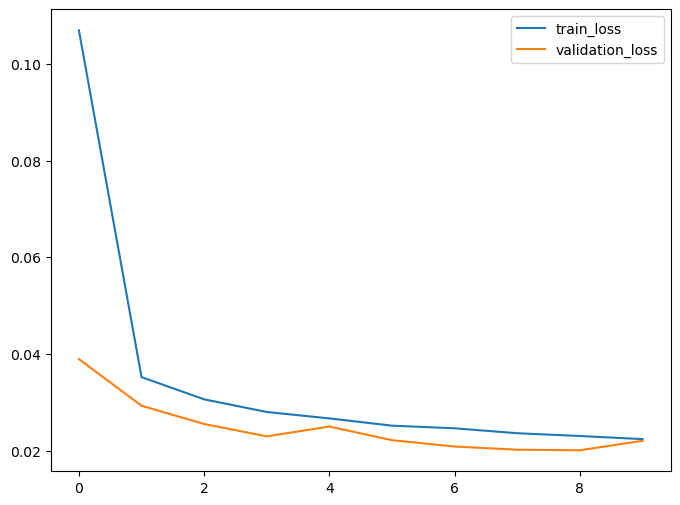

In [95]:
# display losses

plt.figure(figsize=(8,6))

x = range(epochs)
plt.plot(x, train_loss_list, label = 'train_loss')
plt.plot(x, valid_loss_list, label = 'validation_loss')
plt.legend()

---
# Analyze and Experiment

> **TASK**: Write down one or two _initial_ observations about the provided train/validation loss plot. 

> * For each observation, make a hypothesis about what could be causing this behavior. 
> * Then run an experiment to try and improve upon this model and create a smooth training/validation loss graph.

Your final submission should include this improved loss graph. 

**Your observations here:**
> * The Loss appears to drop, and the fluctuates within a range. This could indicate a high learning rate.
> * The Loss does not appear to drop further after the first epoch, this indicates that the number of epochs should not be the issue.


### Evaluate your experiments

How well do your model experiments perform on the test data? 
> **TASK**: Write a test loop to calculate the test accuracy of your models.

In [96]:
# Done Above!!!
## Changed Optimizer to Adam
## Added another FC Layer and added the ReLU() Activation function to each layer
## Decreased the Learning Rate to 0.001

Don't forget to unmount the Trove dataset when you're done!

In [97]:
# UNMOUNT the dataset when you're done
trove.umount(TROVE_URI)

dataset/run_walk_motion@1.0.0 is umounted from /Users/noahgallego/Desktop/Apple-OBC/Loss_Vis_Ex/temp_data/run_walk_motion-1.0.0/data/table
dataset/run_walk_motion@1.0.0 is umounted from /Users/noahgallego/Desktop/Apple-OBC/Loss_Vis_Ex/temp_data/run_walk_motion-1.0.0/data/raw
folder /Users/noahgallego/Desktop/Apple-OBC/Loss_Vis_Ex/temp_data/run_walk_motion-1.0.0/data is removed
terms.md is removed from /Users/noahgallego/Desktop/Apple-OBC/Loss_Vis_Ex/temp_data/run_walk_motion-1.0.0/terms.md
readme.md is removed from /Users/noahgallego/Desktop/Apple-OBC/Loss_Vis_Ex/temp_data/run_walk_motion-1.0.0/readme.md
info.json is removed from /Users/noahgallego/Desktop/Apple-OBC/Loss_Vis_Ex/temp_data/run_walk_motion-1.0.0/info.json


/Users/noahgallego/miniconda3/envs/deep-learning/lib/python3.8/site-packages/httpx/_content.py:202: DeprecationWarning: Use 'content=<...>' to upload raw bytes/text content.
  warnings.warn(message, DeprecationWarning)
